## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import os
import sys
sys.path.append('./waveglow/')
import numpy as np
import torch
import transformers

from hparams import create_hparams
from model import Tacotron2
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
from text.cleaners import text_normalize
from txt2pinyin import txt2pinyin

I1223 22:43:14.442117 140201621862208 file_utils.py:35] PyTorch version 1.1.0 available.
/home/lukeum/.conda/envs/syn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lukeum/.conda/envs/syn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lukeum/.conda/envs/syn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
# uncomment the following line if you want to use the original Tacotron 2
#hparams.bert = False
hparams.sampling_rate = 22050


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [4]:
# specify the path to the pre-trained Tacotron2
checkpoint_path = "../models/taco2/tacotron2_bert"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path))
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [5]:
# specify the path to the pre-trained Waveglow
waveglow_path = '../models/waveglow/waveglow_150k'
waveglow = torch.load(waveglow_path)
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
for m in waveglow.modules():
    if 'Conv' in str(type(m)):
        setattr(m, 'padding_mode', 'zeros')
denoiser = Denoiser(waveglow)

In [6]:
def load_bert(path):
    '''
    Load the Chinese Bert model in the specified folder
    '''
    config_path = os.path.join(path,'bert_config.json')
    model_path = os.path.join(path,'pytorch_model.bin')
    vocab_path = os.path.join(path, 'vocab.txt')
    
    
    config = transformers.BertConfig.from_pretrained(config_path)
    config.output_hidden_states=True
    
    model = transformers.BertModel.from_pretrained(model_path,config=config)
    model.eval()
    
    tokenizer = transformers.BertTokenizer(vocab_path)
    
    return model, tokenizer


def extract_embeddings(model,tokenizer,text,upsampling=True):
    '''
    Extract embeddings from the pre-trained bert model.
    Apply upsampling to ensure that embedding length are the same as the phoneme length
    '''
    
    clean_text = text_normalize(text)
    pinyin_seq = txt2pinyin(clean_text)
    phon_seq = [i for syl in pinyin_seq for i in syl]
    
    inputs = torch.tensor(tokenizer.encode(clean_text)).unsqueeze(0)
    assert inputs[0,0]==101 and inputs[0,-1]==102
    outputs = model(inputs)    
    h = outputs[0].cpu().detach().numpy()
#    del outputs
    h = h[:,1:-1,:]
    assert h.shape[1] == len(pinyin_seq)

    features = [np.tile(h[:,i,:],[1,len(syl),1]) for i,syl in enumerate(pinyin_seq)]
    features = np.concatenate(features,axis=1)
    
    assert features.shape[1] == len(phon_seq)
    assert features.shape[2] == 768
    assert features.shape[0] == 1
    
    return torch.tensor(features).cuda().half()


if hparams.bert == True:
    # specify the path to the BERT folder
    bert_path = '../models/taco2/BZNSYP/chinese_wwm_ext_pytorch'
    bert, tokenizer= load_bert(bert_path)

I1223 22:43:20.232820 140201621862208 configuration_utils.py:182] loading configuration file ../models/taco2/BZNSYP/chinese_wwm_ext_pytorch/bert_config.json
I1223 22:43:20.233330 140201621862208 configuration_utils.py:199] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "pruned_

#### Prepare text input

In [12]:
text = "刚出炉的烧鹅，呈现出枣红色的光泽，甘香油润，卤汁丰盈，放在任何的宴席上都是一道味彩出众的主菜。"
if text[-1] not in  ['。','？','！']:
    text += '。'
sequence = np.array(text_to_sequence(text, ['chinese_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()


In [13]:
if hparams.bert == True:
    features = extract_embeddings(bert,tokenizer,text)
    sequence = (sequence, features)

#### Decode text input and plot results

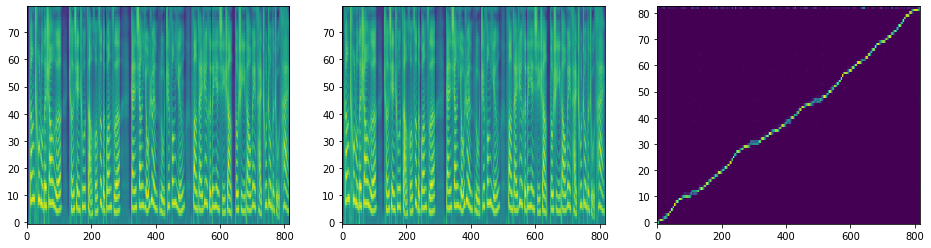

In [14]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [15]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)

ipd.Audio(np.concatenate((np.zeros(500),audio[0].data.cpu().numpy())), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [16]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 